# Preprocessing
lucky is in the process of fixing the function

In [9]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import OneClassSVM
import pandas as pd
import numpy as np

def calculate_cancer_score(df):
    """
    Calculate a cancer score based on risk factors in the binary encoded data.
    Considers values of 2 (True) as indicators of potential risk.
    
    Parameters:
    df (pandas.DataFrame): The input DataFrame with one-hot encoded features
    
    Returns:
    pandas.DataFrame: Original DataFrame with new cancer score columns
    """
    result_df = df.copy()
    
    result_df['cancer_score'] = 0
    
    high_risk_patterns = {
        'age': ['age_60-69', 'age_70-79'],  
        'tumor-size': ['tumor-size_25-29', 'tumor-size_30-34', 'tumor-size_35-39', 
                      'tumor-size_40-44', 'tumor-size_45-49', 'tumor-size_50-54'],  
        'inv-nodes': ['inv-nodes_11-Sep', 'inv-nodes_14-Dec', 'inv-nodes_15-17', 
                     'inv-nodes_24-26'],  
        'node-caps': ['node-caps_yes'],  
        'deg-malig': ['deg-malig']  
    }
    for category, patterns in high_risk_patterns.items():
        for pattern in patterns:
            matching_cols = [col for col in df.columns if pattern in col]
            for col in matching_cols:
            
                result_df['cancer_score'] += (result_df[col] == 2).astype(int)
    max_possible_score = sum(len(patterns) for patterns in high_risk_patterns.values())
    result_df['cancer_score'] = (result_df['cancer_score'] / max_possible_score * 10).round(2)
    
    result_df['cancer_risk_category'] = pd.cut(
        result_df['cancer_score'],
        bins=[0, 2.5, 5, 7.5, 10],
        labels=['Low', 'Moderate', 'High', 'Very High']
    )
    
    return result_df
breast_cancer_df = fetch_ucirepo(id=14)
X = pd.DataFrame(breast_cancer_df.data.features, columns=breast_cancer_df.data.feature_names)
y = pd.Series(breast_cancer_df.data.targets.squeeze(), name='Outcome')
le = LabelEncoder()
y_encoded = le.fit_transform(y)
columns_to_one_hot = [col for col in X.columns if X[col].dtype == 'object']
X = pd.get_dummies(X, columns=columns_to_one_hot)
bool_columns = X.select_dtypes(include=['bool']).columns
for col in bool_columns:
    X[col] = X[col].map({False: 1, True: 2})
X_with_score = calculate_cancer_score(X)
print("\nCancer Score Statistics:")
print(f"Mean Score: {X_with_score['cancer_score'].mean():.2f}")
print(f"Median Score: {X_with_score['cancer_score'].median():.2f}")
print(f"Maximum Score: {X_with_score['cancer_score'].max():.2f}")
print(f"Minimum Score: {X_with_score['cancer_score'].min():.2f}")
print("\nRisk Distribution:")
print(X_with_score['cancer_risk_category'].value_counts().sort_index())

print("\nScore Distribution:")
print(pd.qcut(X_with_score['cancer_score'], q=4).value_counts().sort_index())

X_train, X_test, y_train, y_test = train_test_split(X_with_score, y_encoded, test_size=0.3, random_state=42)



Cancer Score Statistics:
Mean Score: 1.08
Median Score: 0.71
Maximum Score: 2.86
Minimum Score: 0.00

Risk Distribution:
cancer_risk_category
Low          242
Moderate       7
High           0
Very High      0
Name: count, dtype: int64

Score Distribution:


ValueError: Bin edges must be unique: Index([0.0, 0.71, 0.71, 1.43, 2.86], dtype='float64', name='cancer_score').
You can drop duplicate edges by setting the 'duplicates' kwarg

# RANDOM FOREST
lucky did this

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)


0.6976744186046512

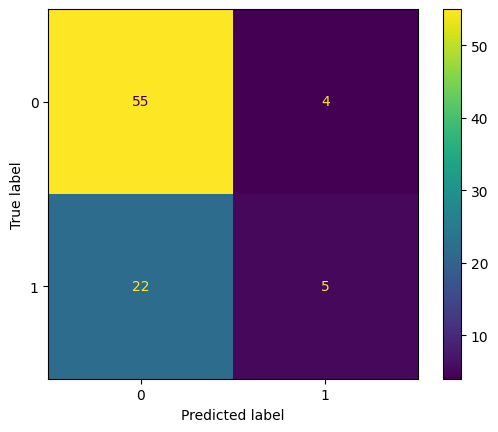

In [15]:
import pandas as pd
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)

[0.12601485 0.         0.02265144 0.03137114 0.03452349 0.03091848
 0.00314504 0.02579349 0.01072746 0.0280005  0.00427985 0.01632284
 0.01634239 0.03251203 0.03139542 0.03843623 0.02165417 0.01980928
 0.00505596 0.01145644 0.00230342 0.04390264 0.01420547 0.00355131
 0.00622595 0.         0.03468115 0.01969084 0.04493999 0.03502714
 0.03880411 0.03837775 0.01245847 0.04221682 0.05018467 0.01466276
 0.02882347 0.0333187  0.02621483] Index(['deg-malig', 'age_20-29', 'age_30-39', 'age_40-49', 'age_50-59',
       'age_60-69', 'age_70-79', 'menopause_ge40', 'menopause_lt40',
       'menopause_premeno', 'tumor-size_0-4', 'tumor-size_14-Oct',
       'tumor-size_15-19', 'tumor-size_20-24', 'tumor-size_25-29',
       'tumor-size_30-34', 'tumor-size_35-39', 'tumor-size_40-44',
       'tumor-size_45-49', 'tumor-size_50-54', 'tumor-size_9-May',
       'inv-nodes_0-2', 'inv-nodes_11-Sep', 'inv-nodes_14-Dec',
       'inv-nodes_15-17', 'inv-nodes_24-26', 'inv-nodes_5-Mar',
       'inv-nodes_8-Jun', 

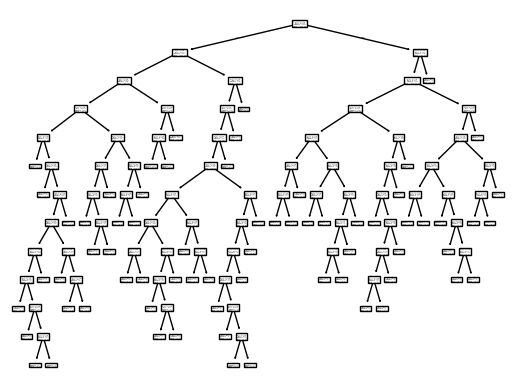

In [17]:
#recall
5/(22+5)
print(rf.feature_importances_, X.columns)
import matplotlib.pyplot as plt
rf_tree = rf.estimators_[4]
tree.plot_tree(rf_tree)
plt.savefig("rf_tree.svg")

# SVM

In [18]:
classifer = make_pipeline(StandardScaler(), OneClassSVM(gamma='auto'))
classifer.fit(X_train)
y_pred_svm = classifer.predict(X_test)
pred = pd.DataFrame({'svm': y_pred_svm})
pred['svm_pred'] = np.where(pred['svm'] == -1, 1, 0)
y_pred_svm = pred['svm_pred']
precision_macro = precision_score(y_test, y_pred_svm, average='macro')
print("OneClassSVM Macro Precision:", precision_macro)

OneClassSVM Macro Precision: 0.5203252032520325


# PCA + Logistic Regression
lucky will do this


Explained Variance Ratio:
[0.10985589 0.08103837 0.06704253 0.05542545 0.04546581 0.04314439
 0.04070627 0.0400331  0.0381696  0.03657121 0.03476172 0.03389237
 0.03284144]
0.7325581395348837


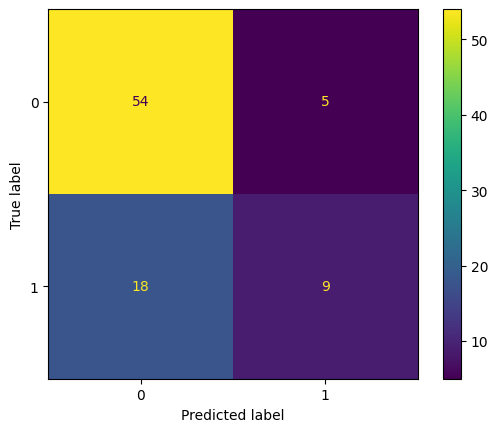

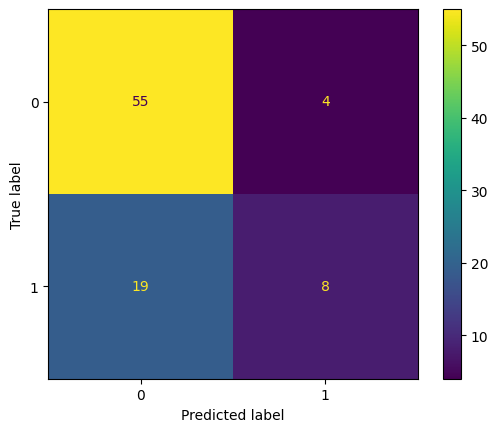

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
#had to do a new split bc old one didn't drop the cancer_score columns
X_train, X_test, y_train, y_test = train_test_split(
    X_with_score.drop(['cancer_score', 'cancer_risk_category'], axis=1, errors='ignore'),
    y_encoded,
    test_size=0.3,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
pca = PCA(n_components=13)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
explained_variance = pca.explained_variance_ratio_
print("\nExplained Variance Ratio:")
print(explained_variance)
#Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42).fit(X_train,y_train)
y_predicted = model.predict(X_test)

print(model.score(X_test, y_test))
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted)
model = LogisticRegression(random_state=42).fit(X_train_pca, y_train)
model.score(X_test_pca, y_test)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_test_pca, y_test)


